In [ ]:
USE_COLAB = True

if USE_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")
    %cd /content/drive/MyDrive/data-valuation/
    !pip install -qr requirements.txt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data-valuation
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.5/108.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.8/526.8 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.6/867.6 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.2/126.2 kB 12.1 MB/s et

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import collections
import textwrap
import warnings
from functools import partial, reduce
from importlib import reload
from pathlib import Path
from pprint import pprint

import clip
import matplotlib.pyplot
import matplotlib.pyplot as plt
import medmnist
import numpy as np
import pandas as pd
import torch
from src import valuation
from opendataval.dataloader import DataFetcher
from opendataval.dataval import (
    DataOob,
    DataShapley,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)
from opendataval.model import ClassifierSkLearnWrapper, RegressionSkLearnWrapper
from scipy.stats import kendalltau, pearsonr
from sklearn import random_projection
from sklearn.decomposition import PCA
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from PIL import Image
from sklearn.metrics import DistanceMetric, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Normalizer
from torchvision.transforms import Compose, ToPILImage
from tqdm.notebook import tqdm
from vendi_score import vendi
import clip
from sklearn.metrics.cluster import homogeneity_score
from sklearn.metrics import adjusted_mutual_info_score, v_measure_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering
plt.rcParams["font.family"] = "serif"
fig_dir = Path("figures")
from collections import defaultdict
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [ ]:
saved_embedding_path = Path("embeddings")

med_224 = {
    "bloodmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_bloodmnist_224.pt"
    ),
    "breastmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_breastmnist_224.pt"
    ),
    "chestmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_chestmnist_224.pt"
    ),
    "dermamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_dermamnist_224.pt"
    ),
    "pathmnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_pathmnist_224.pt"
    ),
    "retinamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_retinamnist_224.pt"
    ),
    "tissuemnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_tissuemnist_224.pt"
    ),
    "organamnist": torch.load(
        saved_embedding_path / "clip_embedding_medmnist_organamnist_224.pt"
    )
}

In [ ]:
cifar = torch.load("embeddings/clip_embedding_cifar_seller.pt")
fashion = torch.load("embeddings/clip_embedding_fashion_seller.pt")
mnist = torch.load("embeddings/clip_embedding_mnist_seller.pt")

# Varying Number of Sample/Proportion of Duplicates

In [ ]:
# We will not include dermamnist and retinamnist in these experiments since they have less samples,
# to keep a consistent number of 10,000 (maximum) sellers
for buyer in ['bloodmnist', 'chestmnist', 'pathmnist', 'tissuemnist', 'dermamnist', 'organamnist', 'retinamnist']:
  print(med_224[buyer]['embeddings'].shape)
print(cifar['images'].shape)
print(fashion['images'].shape)
print(mnist['images'].shape)

torch.Size([11959, 512])
torch.Size([78468, 512])
torch.Size([89996, 512])
torch.Size([165466, 512])
torch.Size([7007, 512])
torch.Size([34561, 512])
torch.Size([1080, 512])
torch.Size([10000, 512])
torch.Size([10000, 512])
torch.Size([60000, 512])


In [ ]:
metrics = ["relevance", "l2", "cosine", "diversity", "volume", "vendi", "dispersion"]

# Plotting the results
def plot_results(x_label, x_values, y_values):
  num_metrics = len(metrics)
  fig, axs = plt.subplots(num_metrics, 1, figsize=(10, 12), sharex=True)
  fig.suptitle(f'Average Relevance/Diversity Values vs. {x_label}')

  # Loop through each metric and create a separate subplot
  for i, metric in enumerate(metrics):
      axs[i].plot(x_values, y_values[metric], label=metric)
      axs[i].set_ylabel("Average " + metric.capitalize())
      axs[i].legend(loc="upper left")

  # Set common x-axis label
  axs[-1].set_xlabel(x_label)

  plt.show()

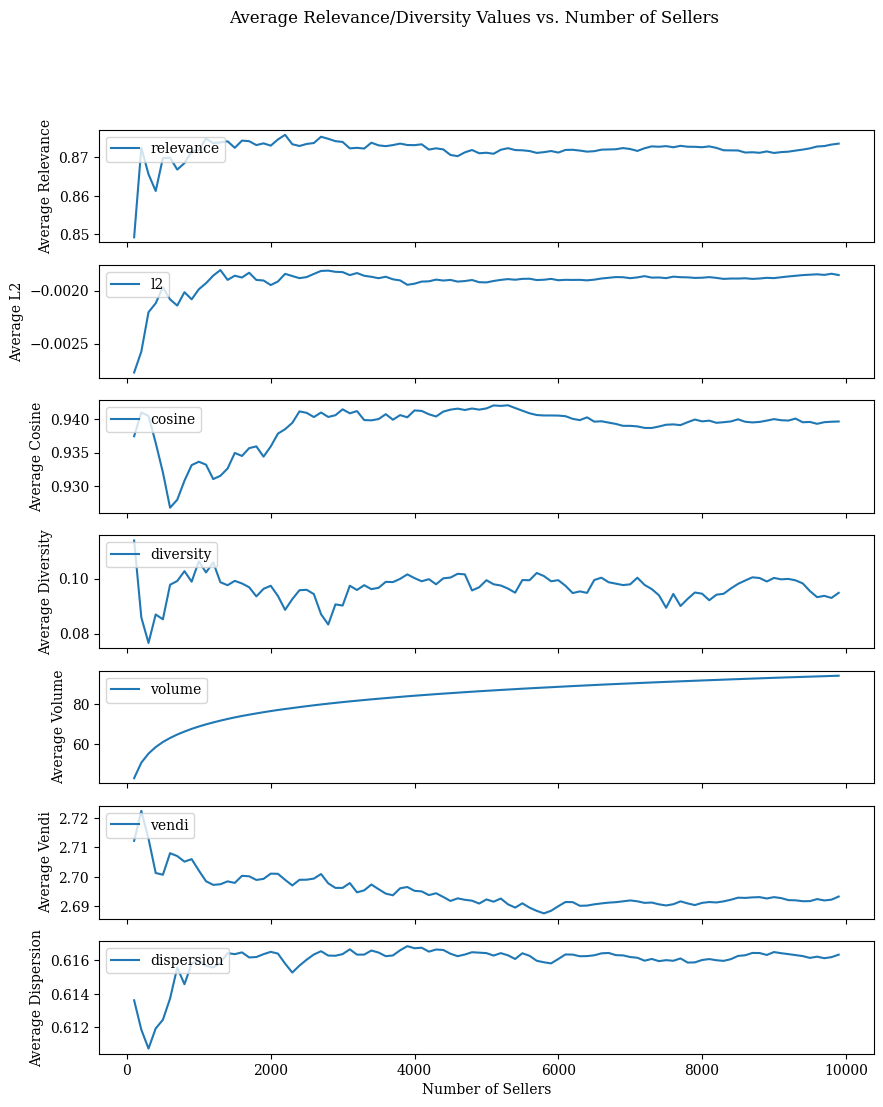

In [ ]:
# Vary num_seller, in domain (averaged over MedMNIST datasets)

num_buyer = 100
num_seller_values = range(100, 10000, 100)
datasets = ['bloodmnist', 'chestmnist', 'pathmnist', 'tissuemnist', 'organamnist']

results = {metric: [] for metric in metrics}

for num_seller in num_seller_values:
    metric_sums = {metric: 0 for metric in metrics}

    for buyer in datasets:
        buyer_data = med_224[buyer]['embeddings'][-num_buyer:]
        seller_data = med_224[buyer]['embeddings'][:num_seller]

        seller_values = valuation.get_value(
            buyer_data,
            seller_data,
            n_components=10
        )

        for metric in metrics:
            metric_sums[metric] += seller_values[metric]

    for metric in metrics:
        avg_value = metric_sums[metric] / len(datasets)
        results[metric].append(avg_value)

plot_results("Number of Sellers", num_seller_values, results)

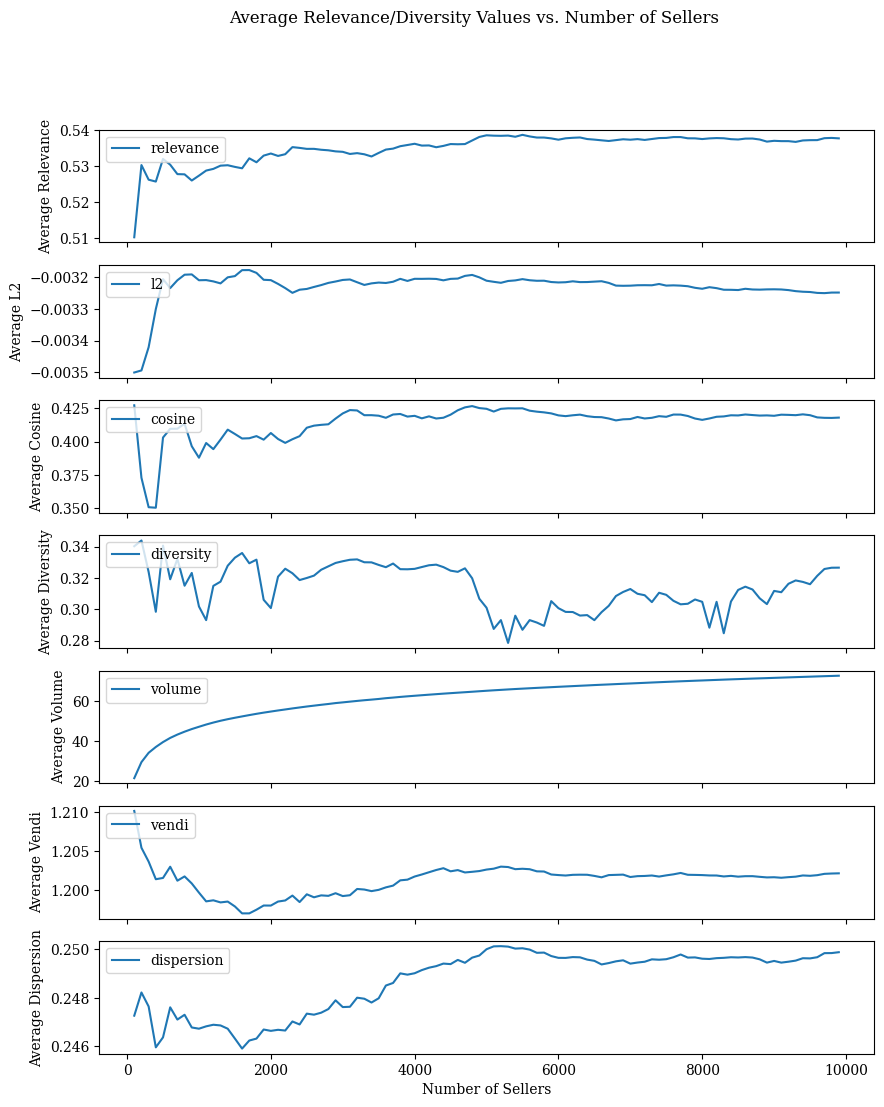

In [ ]:
# Vary num_seller, out of domain (averaged over CIFAR, Fashion, and MNIST datasets)

num_buyer = 100
buyer = 'bloodmnist'
num_seller_values = range(100, 10000, 100)
datasets = [cifar, fashion, mnist]

results = {metric: [] for metric in metrics}
for num_seller in num_seller_values:
    metric_sums = {metric: 0 for metric in metrics}

    for seller in datasets:
        buyer_data = med_224[buyer]['embeddings'][-num_buyer:]
        seller_data = seller['images'][:num_seller]

        seller_values = valuation.get_value(
            buyer_data,
            seller_data,
            n_components=10
        )

        for metric in metrics:
            metric_sums[metric] += seller_values[metric]

    for metric in metrics:
        avg_value = metric_sums[metric] / len(datasets)
        results[metric].append(avg_value)

plot_results("Number of Sellers", num_seller_values, results)

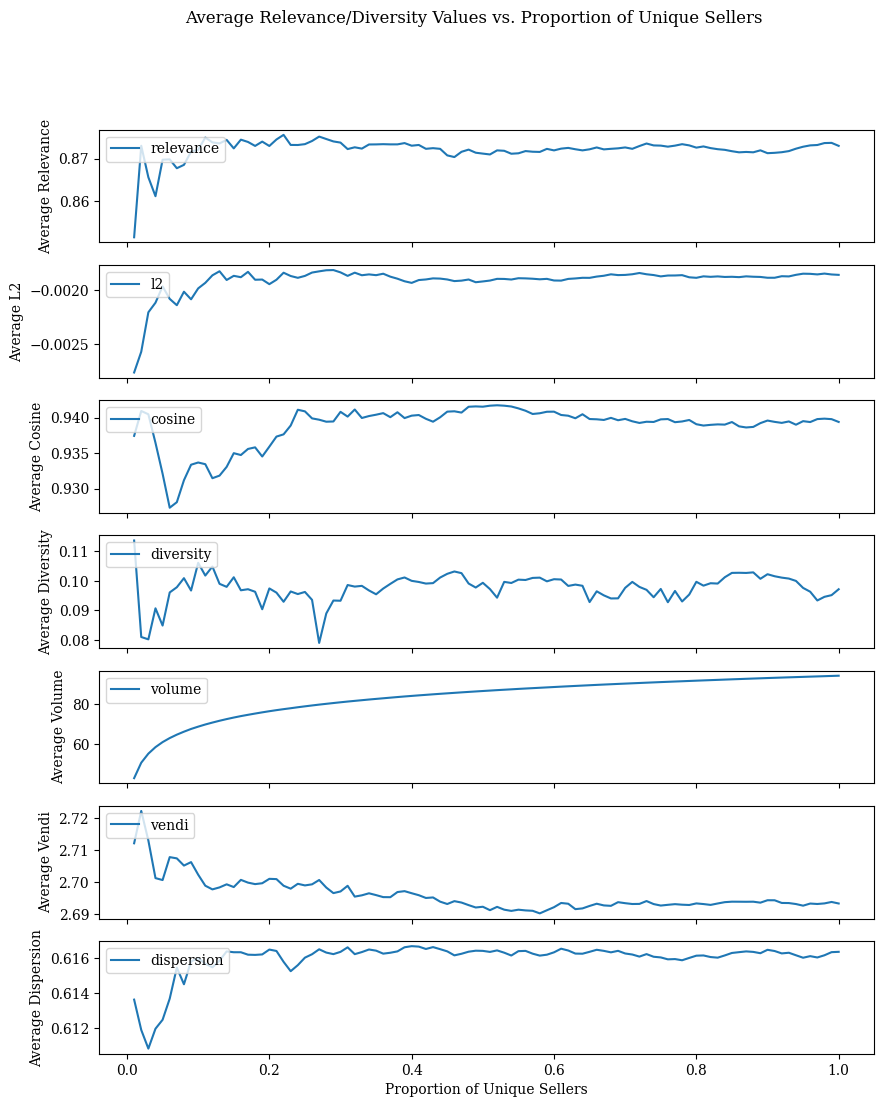

In [ ]:
# Vary proportion of duplicates, in domain (averaged over MedMNIST datasets)

num_buyer = 100
num_seller = 10000
uniq_prop_values = np.arange(0.01, 1.01, 0.01)
datasets = ['bloodmnist', 'chestmnist', 'pathmnist', 'tissuemnist', 'organamnist']

results = {metric: [] for metric in metrics}

for uniq_prop in uniq_prop_values:
    metric_sums = {metric: 0 for metric in metrics}

    for buyer in datasets:
        buyer_data = med_224[buyer]['embeddings'][-num_buyer:]

        unique_count = int(num_seller * uniq_prop)
        duplicate_count = num_seller - unique_count
        original_seller_data = med_224[buyer]['embeddings'][:unique_count]
        duplicated_data = np.tile(original_seller_data, (duplicate_count // unique_count + 1, 1))[:duplicate_count]  # Ensure correct size
        seller_data = np.concatenate((original_seller_data, duplicated_data), axis=0)

        seller_values = valuation.get_value(
            buyer_data,
            seller_data,
            n_components=10
        )

        for metric in metrics:
            metric_sums[metric] += seller_values[metric]

    for metric in metrics:
        avg_value = metric_sums[metric] / len(datasets)
        results[metric].append(avg_value)

plot_results("Proportion of Unique Sellers", uniq_prop_values, results)

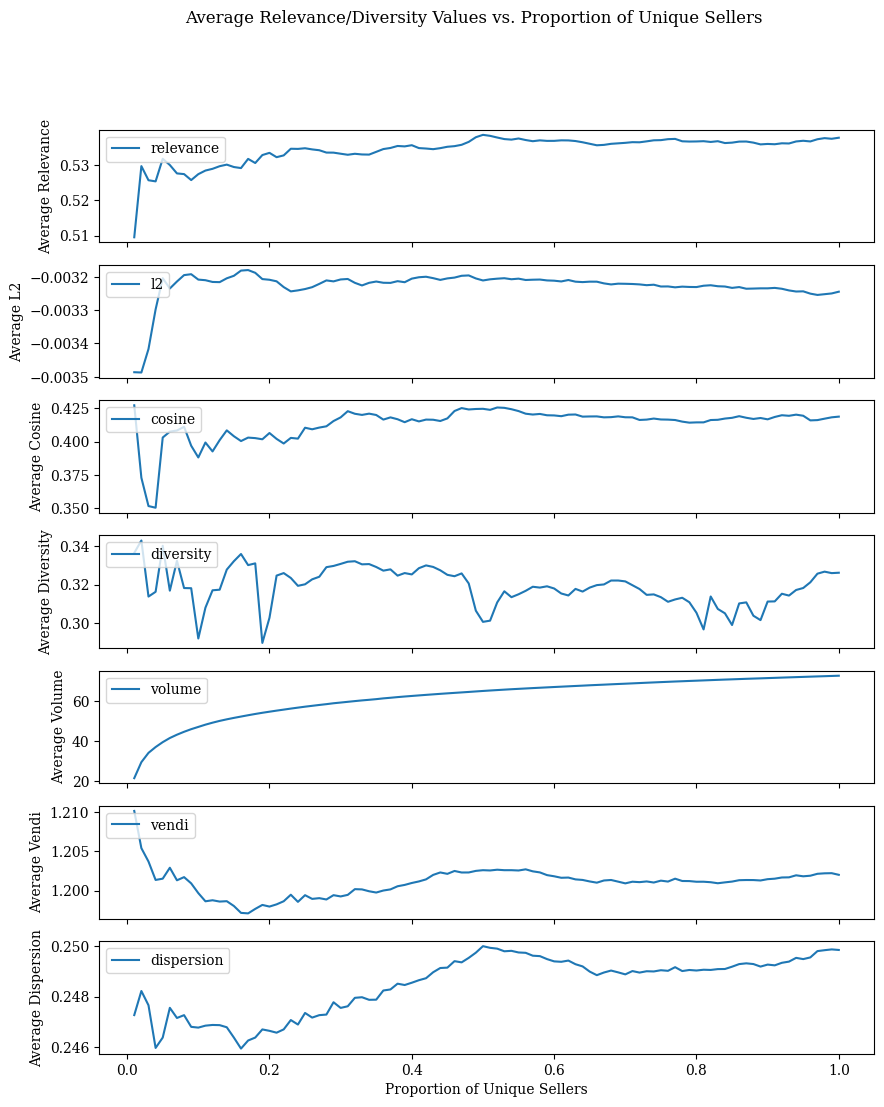

In [ ]:
# Vary proportion of duplicates, out of domain (averaged over CIFAR, Fashion, and MNIST datasets)

num_buyer = 100
buyer = 'bloodmnist'
num_seller = 10000
uniq_prop_values = np.arange(0.01, 1.01, 0.01)
datasets = [cifar, fashion, mnist]

results = {metric: [] for metric in metrics}

for uniq_prop in uniq_prop_values:
    metric_sums = {metric: 0 for metric in metrics}

    for seller in datasets:
        buyer_data = med_224[buyer]['embeddings'][-num_buyer:]

        unique_count = int(num_seller * uniq_prop)
        duplicate_count = num_seller - unique_count
        original_seller_data = seller['images'][:unique_count]
        duplicated_data = np.tile(original_seller_data, (duplicate_count // unique_count + 1, 1))[:duplicate_count]  # Ensure correct size
        seller_data = np.concatenate((original_seller_data, duplicated_data), axis=0)

        seller_values = valuation.get_value(
            buyer_data,
            seller_data,
            n_components=10
        )

        for metric in metrics:
            metric_sums[metric] += seller_values[metric]

    for metric in metrics:
        avg_value = metric_sums[metric] / len(datasets)
        results[metric].append(avg_value)

plot_results("Proportion of Unique Sellers", uniq_prop_values, results)

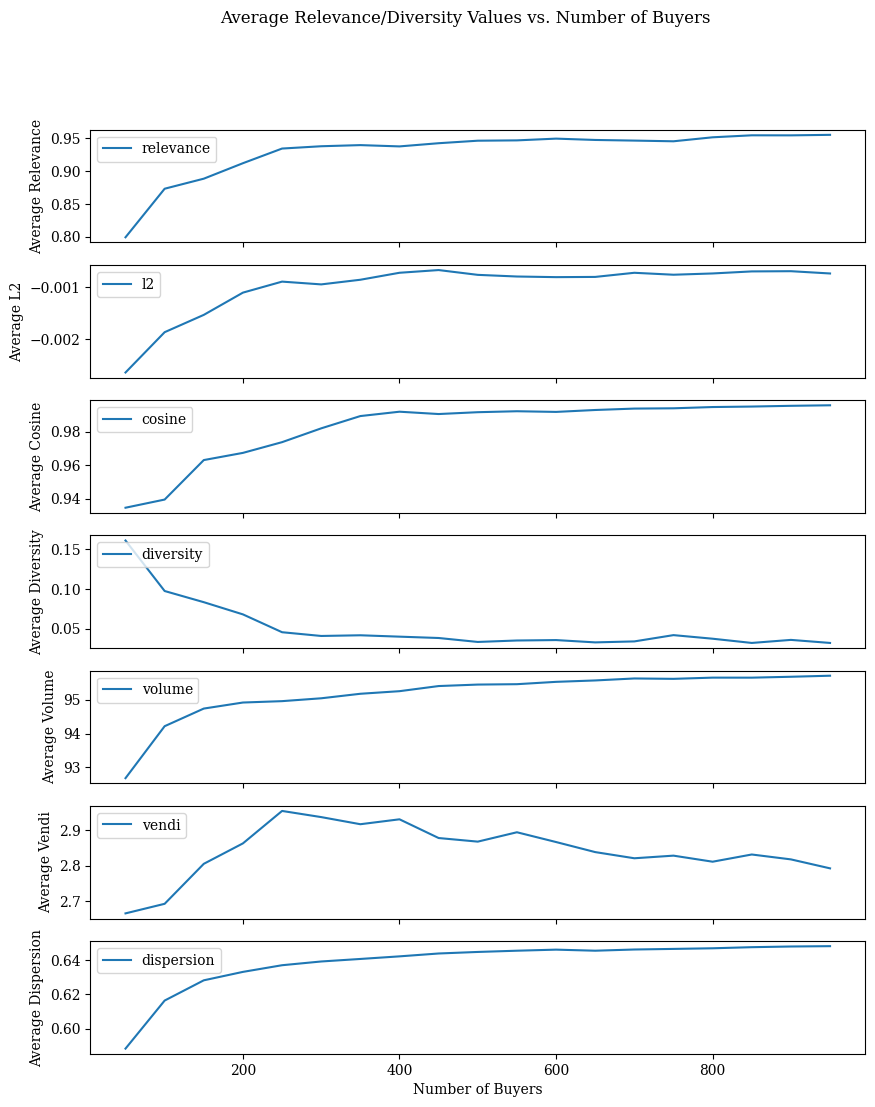

In [ ]:
# Vary num_buyer, in domain (averaged over MedMNIST datasets)

num_buyer_values = range(50, 1000, 50)
num_seller = 10000
datasets = ['bloodmnist', 'chestmnist', 'pathmnist', 'tissuemnist', 'organamnist']

results = {metric: [] for metric in metrics}

for num_buyer in num_buyer_values:
    metric_sums = {metric: 0 for metric in metrics}

    for buyer in datasets:
        buyer_data = med_224[buyer]['embeddings'][-num_buyer:]
        seller_data = med_224[buyer]['embeddings'][:num_seller]

        seller_values = valuation.get_value(
            buyer_data,
            seller_data,
            n_components=10
        )

        for metric in metrics:
            metric_sums[metric] += seller_values[metric]

    for metric in metrics:
        avg_value = metric_sums[metric] / len(datasets)
        results[metric].append(avg_value)

plot_results("Number of Buyers", num_buyer_values, results)

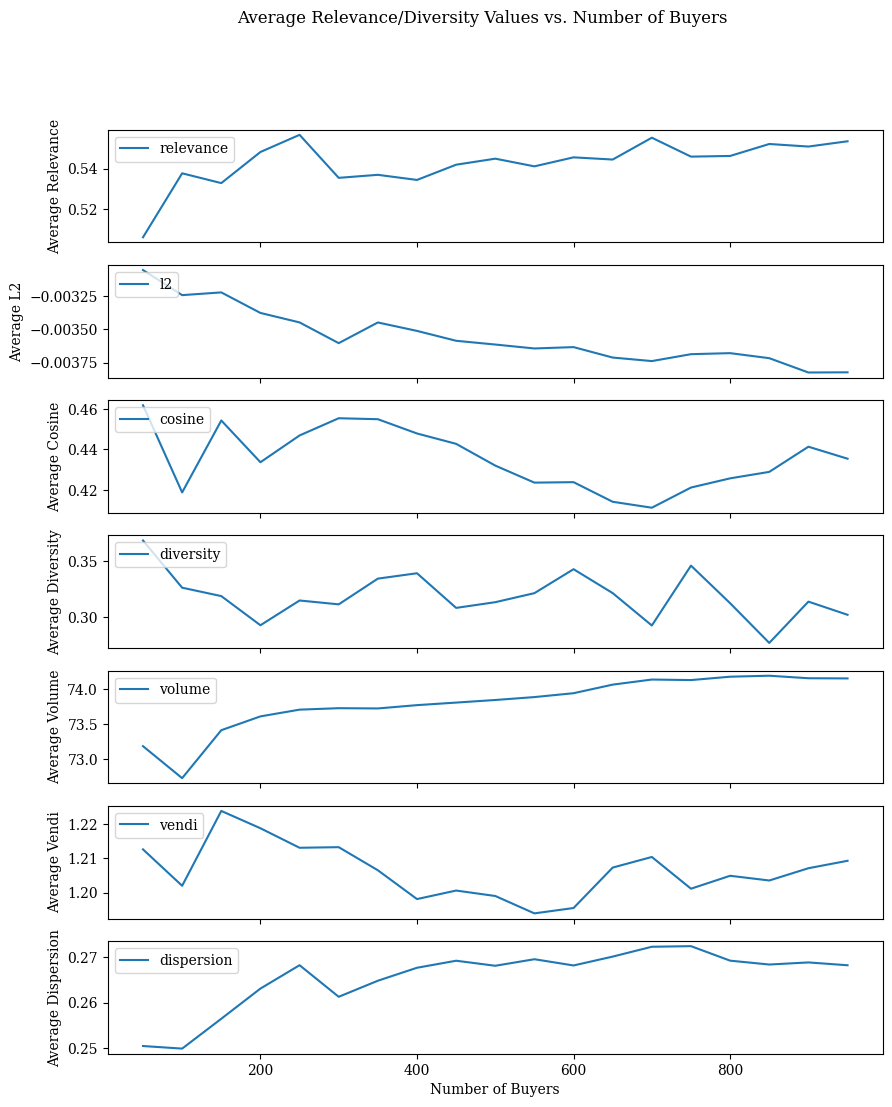

In [ ]:
# Vary num_buyer, out of domain (averaged over CIFAR, Fashion, and MNIST datasets)

num_buyer_values = range(50, 1000, 50)
buyer = 'bloodmnist'
num_seller = 10000
datasets = [cifar, fashion, mnist]

results = {metric: [] for metric in metrics}

for num_buyer in num_buyer_values:
    metric_sums = {metric: 0 for metric in metrics}

    for seller in datasets:
        buyer_data = med_224[buyer]['embeddings'][-num_buyer:]
        seller_data = seller['images'][:num_seller]

        seller_values = valuation.get_value(
            buyer_data,
            seller_data,
            n_components=10
        )

        for metric in metrics:
            metric_sums[metric] += seller_values[metric]

    for metric in metrics:
        avg_value = metric_sums[metric] / len(datasets)
        results[metric].append(avg_value)

plot_results("Number of Buyers", num_buyer_values, results)

# OpenDataVal Experiments

In [ ]:
sev_classes = {
    "pathmnist": [8, 7, 6],
    "dermamnist": [4, 1, 0],
    "bloodmnist": [6, 5, 4],
    "chestmnist": [6, 7],
    "breastmnist": [0],
    "tissuemnist": [2, 5, 6],
    "retinamnist": [1, 2, 3],
    "organamnist": [7, 8, 3, 6],
}

In [ ]:
total_classes = {
    k: len(v['label']) for k, v in medmnist.INFO.items()
}
total_classes

{'pathmnist': 9,
 'chestmnist': 14,
 'dermamnist': 7,
 'octmnist': 4,
 'pneumoniamnist': 2,
 'retinamnist': 5,
 'breastmnist': 2,
 'bloodmnist': 8,
 'tissuemnist': 8,
 'organamnist': 11,
 'organcmnist': 11,
 'organsmnist': 11,
 'organmnist3d': 11,
 'nodulemnist3d': 2,
 'adrenalmnist3d': 2,
 'fracturemnist3d': 3,
 'vesselmnist3d': 2,
 'synapsemnist3d': 2}

In [ ]:
def sample_dirichlet_by_class(
    x, y, num_sellers=10, num_samples=1000, add_to_alpha=1, min_samples=0
):
    y = y.squeeze().numpy()
    class_counts = np.bincount(y)
    class_prop = class_counts / class_counts.sum()
    class_weights = np.random.dirichlet(add_to_alpha + class_prop, size=num_sellers)
    sample_weights = {i: v[y] for i, v in enumerate(class_weights)}
    sample_weights = {k: v / v.sum() for k, v in sample_weights.items()}

    rang = np.arange(len(x))
    seller_indexes = {
        k: np.random.choice(rang, size=num_samples, replace=False, p=v)
        for k, v in sample_weights.items()
    }
    if min_samples > 0:
        new_index = []
        for c in np.unique(y):
            class_index = np.where(y == c)[0][:min_samples]
            new_index.extend(class_index)

        for k in seller_indexes:
            seller_indexes[k][: len(new_index)] = new_index

    return seller_indexes

In [ ]:
def compute_utility(
    x_train,
    y_train,
    x_test,
    y_test,
    model=partial(LogisticRegression, max_iter=200),
    # utility=accuracy_score,
    utility=partial(f1_score, average="macro"),
    # utility=partial(f1_score, average=None),
    n_clusters=None,
):
    if n_clusters is not None:
        M = model(n_clusters=n_clusters )
    else:
        M = model()
    M.fit(x_train, y_train)
    y_pred = M.predict(x_test)
    return utility(y_test, y_pred)


binary_utility = partial(compute_utility, model=partial(LogisticRegression, max_iter=200), utility=partial(f1_score, average="macro"))
multi_utility = partial(compute_utility, model=partial(RandomForestClassifier, n_estimators=10, max_depth=5), utility=partial(f1_score, average="macro"))
cluster_utility = partial(compute_utility, model=partial(KMeans, n_clusters=10, n_init='auto'), utility=lambda true, pred: homogeneity_score(true.squeeze(), pred.squeeze()))


In [ ]:
def get_values(
    train_x,
    train_y,
    val_x,
    val_y,
    test_x,
    test_y,
    classifier,
    num_class=2,
    metric=mean_squared_error,
    random_state=0,
):
    fetcher = DataFetcher.from_data_splits(
        train_x, train_y, val_x, val_y, test_x, test_y, one_hot=False
    )

    if classifier == "bin":
      model = ClassifierSkLearnWrapper(LogisticRegression, num_classes=num_class, max_iter=200)
    elif classifier == "multi":
      model = ClassifierSkLearnWrapper(RandomForestClassifier, num_classes=num_class, n_estimators=10, max_depth=5)
    else:
      model = ClassifierSkLearnWrapper(KMeans, num_classes=num_class, n_clusters=10, n_init='auto')

    # ame_values = (
    #     AME(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    # banz_values = (
    #     DataBanzhaf(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    # oob_values = (
    #     opendataval.dataval.DataOob(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    # shap_values = (
    #     DataShapley(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    # beta_values = (
    #     BetaShapley(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    # loo_values = (
    #     LeaveOneOut(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    # dvrl_values = (
    #     DVRL(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    lava_values = (
        LavaEvaluator(random_state=random_state)
        .train(fetcher=fetcher, pred_model=model)
        .data_values
    )
    # influence_values = (
    #     InfluenceSubsample(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    knn_values = (
        KNNShapley(random_state=random_state)
        .train(fetcher=fetcher, pred_model=model)
        .data_values
    )
    # robust_values = (
    #     RobustVolumeShapley(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )
    # random_values = (
    #     RandomEvaluator(random_state=random_state)
    #     .train(fetcher=fetcher, pred_model=model)
    #     .data_values
    # )

    return {
        # "AME": np.mean(ame_values),
        # "Banzhaf": np.mean(banz_values),
        # "OOB": np.mean(oob_values),
        # "Shapley": np.mean(shap_values),
        # "Beta Shapley": np.mean(beta_values),
        # "Robust Shapley": np.mean(robust_values),
        "KNN Shapley": -np.mean(knn_values),            # Need to negate KNN Shapley
        # "LOO": np.mean(loo_values),
        # "DVRL": np.mean(dvrl_values),
        "LAVA": np.mean(lava_values),
        # "Influence": np.mean(influence_values),
        # "Random": np.mean(random_values),
    }

In [ ]:
# Run this to hide the extra progress bars in the output
import tqdm
class _TQDM(tqdm.tqdm):
    def __init__(self, *argv, **kwargs):
        kwargs['disable'] = True
        if kwargs.get('disable_override', 'def') != 'def':
            kwargs['disable'] = kwargs['disable_override']
        super().__init__(*argv, **kwargs)
tqdm.tqdm = _TQDM

from tqdm.notebook import tqdm

In [ ]:
import pickle
import warnings
warnings.filterwarnings('ignore')

datasets = ["bloodmnist", "dermamnist", 'retinamnist', 'breastmnist', "pathmnist", 'tissuemnist', 'organamnist']

odv_results = defaultdict(dict)

for d in datasets:
    x = med_224[d]["embeddings"].float()
    y = med_224[d]["labels"]

    if d == 'breastmnist':
        num_buyer = 50
        num_samples = 250
        print('breast')
    elif d == 'dermamnist':
        num_buyer = 100
        num_samples = 1500
        print('derma')
    elif d == 'pathmnist':
        num_buyer = 100
        num_samples = 1500
        print('path')
    elif d == 'retinamnist':
        num_buyer = 100
        num_samples = 500
        print('retina')
    elif d == 'Tissuemnist':
        num_buyer = 1500
        num_samples = 25000
        print('tissue')
    else:
        num_buyer = 500
        num_samples = 5000
        print('other')

    num_buyer = 20
    num_samples = 100

    x_dev, x_test, y_dev, y_test = train_test_split(x, y, test_size=0.3)
    print(x_dev.shape, x_test.shape)

    # cs = torch.tensor([4, 1, 0])
    cs = torch.tensor(sev_classes[d])

    if d == 'chestmnist':
        buyer_index = reduce(
            torch.logical_or,
            torch.chunk(y_test[:, cs], len(cs), dim=1)
        ).flatten()
    else:
        buyer_index = torch.isin(y_test.squeeze(), cs)

    x_buyer = x_test[buyer_index][:num_buyer]
    y_buyer = y_test[buyer_index][:num_buyer]

    class_bc = []
    vs = []
    bin_opendataval = []
    multi_opendataval = []
    cluster_opendataval = []
    bin_us = []
    multi_us = []
    cluster_us = []
    num_corr_class = []

    for i, (k, v) in tqdm(
        enumerate(sample_dirichlet_by_class(
            x_dev, y_dev, num_sellers=500, num_samples=num_samples, add_to_alpha=0.2, min_samples=1
        ).items())
    ):
        x_k = x_dev[v]
        y_k = y_dev.squeeze()[v]

        bc = np.bincount(y_k, minlength=total_classes[d])
        class_bc.append(bc)

        total = 0
        for c in cs:
            total += bc[c]
        num_corr_class.append(total)

        # get opendataval values
        x_k_train, x_k_val, y_k_train, y_k_val = train_test_split(x_k, y_k, test_size=0.2)

        odv_bin = get_values(x_k_train, y_k_train, x_k_val, y_k_val, x_test, y_test, "bin")
        bin_opendataval.append(odv_bin)
        odv_multi = get_values(x_k_train, y_k_train, x_k_val, y_k_val, x_test, y_test, "multi", num_class=len(sev_classes[d]))
        multi_opendataval.append(odv_multi)
        odv_cluster = get_values(x_k_train, y_k_train, x_k_val, y_k_val, x_test, y_test, "cluster", num_class=len(sev_classes[d]))
        cluster_opendataval.append(odv_cluster)

        # get diversity/relevance values
        v = valuation.get_value(x_buyer, x_k)
        vs.append(v)

        bin_u = binary_utility(
            x_k,
            torch.isin(y_k, cs),
            x_test,
            buyer_index,
        )

        multi_u = multi_utility(
            x_k,
            y_k,
            x_test,
            y_test,
        )

        cluster_u = cluster_utility(
            x_k,
            y_k,
            x_test,
            y_test,
            n_clusters=len(sev_classes[d]),
        )

        bin_us.append(bin_u)
        multi_us.append(multi_u)
        cluster_us.append(cluster_u)

        if i % 20 == 0:
            print(k, bc, f'{bin_u:.2f}', f'{multi_u:.2f}', f'{cluster_u:.2f}', {k: round(v_, 2) for k, v_ in v.items()}, {k: v_ for k, v_ in odv_bin.items()}, {k: v_ for k, v_ in odv_multi.items()}, {k: v_ for k, v_ in odv_cluster.items()})

    odv_results[d]['class_bc'] = class_bc
    odv_results[d]['vs'] = vs
    odv_results[d]['bin_opendataval'] = bin_opendataval
    odv_results[d]['multi_opendataval'] = multi_opendataval
    odv_results[d]['cluster_opendataval'] = cluster_opendataval
    odv_results[d]['bin_us'] = bin_us
    odv_results[d]['multi_us'] = multi_us
    odv_results[d]['cluster_us'] = cluster_us
    odv_results[d]['num_corr_class'] = num_corr_class


In [ ]:
# Save results
import pickle
with open('odvoutput.pickle', 'wb') as file:
    # Serialize and write the variable to the file
    pickle.dump(odv_results, file)

In [ ]:
# Load Results
import pickle
odv_results = None
with open('odvoutput.pickle', 'rb') as file:
    # Deserialize and retrieve the variable from the file
    odv_results = pickle.load(file)

In [ ]:
table = {}
for y in ["bin", "multi", "cluster"]:
  table[y] = {}
  for x in ["l2", "cosine", "relevance", "dispersion", "volume", "vendi", "KNN Shapley", "LAVA"]:
    table[y][x] = {}
    for d in ["bloodmnist", "dermamnist", 'retinamnist', "pathmnist", 'tissuemnist', 'organamnist']:
      table[y][x][d] = None

for d in ["bloodmnist", "dermamnist", 'retinamnist', "pathmnist", 'tissuemnist', 'organamnist']:
  class_bc = odv_results[d]['class_bc']
  vs = odv_results[d]['vs']
  bin_odv = odv_results[d]['bin_opendataval']
  multi_odv = odv_results[d]['multi_opendataval']
  cluster_odv = odv_results[d]['cluster_opendataval']
  bin_us = odv_results[d]['bin_us']
  multi_us= odv_results[d]['multi_us']
  cluster_us = odv_results[d]['cluster_us']
  num_corr_class = odv_results[d]['num_corr_class']

  y_dict = {
      "bin": bin_us,
      "multi": multi_us,
      "cluster": cluster_us
  }

  for (y_name, _y) in y_dict.items():
    if y_name == "bin":
      odv = bin_odv
    elif y_name == "multi":
      odv = multi_odv
    elif y_name == "cluster":
      odv = cluster_odv

    x_dict = {
      "l2": [v["l2"] for v in vs],
      "cosine": [v["cosine"] for v in vs],
      "relevance": [v["relevance"] for v in vs],
      "dispersion": [v["dispersion"] for v in vs],
      "volume": [v["volume"] for v in vs],
      "vendi": [v["vendi"] for v in vs],
      "KNN Shapley": [v["KNN Shapley"] for v in odv],
      "LAVA": [v["LAVA"] for v in odv],
    }

    for (x_name, _x) in x_dict.items():
      r = kendalltau(_x, _y)
      table[y_name][x_name][d] = r.statistic

In [ ]:
for y in table:
    print(y, end="\t\t")
    max_x_length = max(len(x) for x in table[y])

    d_values = list(table[y][next(iter(table[y]))].keys())
    for d in d_values:
        print(d, end="\t")
    print()

    for x in table[y]:
        print(x.ljust(max_x_length), end="\t")
        for d in d_values:
            print('%.4f' % table[y][x][d], end="\t\t")
        print()
    print('\n')


bin		bloodmnist	dermamnist	retinamnist	pathmnist	tissuemnist	organamnist	
l2         	0.2316		0.1134		0.1979		0.0807		0.0119		0.0481		
cosine     	0.1478		0.0456		0.3147		0.0596		-0.0680		0.0331		
relevance  	0.1422		0.3035		0.1067		0.0568		0.1590		0.0178		
dispersion 	0.1837		0.3472		0.0416		0.0368		0.2206		0.1113		
volume     	0.2590		0.4006		0.1080		0.1931		0.2473		0.1521		
vendi      	0.1757		0.3468		-0.0221		0.1079		0.1933		0.0482		
KNN Shapley	0.2827		0.4952		0.3810		0.3225		0.2692		0.0377		
LAVA       	0.0041		-0.0022		0.0011		0.0086		-0.0246		0.0226		


multi		bloodmnist	dermamnist	retinamnist	pathmnist	tissuemnist	organamnist	
l2         	0.1667		0.1703		0.4518		-0.0746		-0.0149		-0.0319		
cosine     	0.0291		0.0380		0.4939		-0.0933		-0.0367		0.1103		
relevance  	0.0215		0.6609		0.6031		-0.1133		0.0034		-0.0664		
dispersion 	0.2018		0.7092		0.5328		0.1982		0.2932		0.2113		
volume     	0.1421		0.7501		0.6059		0.2434		0.2469		0.2439		
vendi      	0.2298		0.6947		0.4890		0.1675		

<ipython-input-44-511a7f5f20df>:33: RankWarning: Polyfit may be poorly conditioned
  coefficients = np.polyfit(_x, _y, 10)# Fit the polynomial (degree 2)


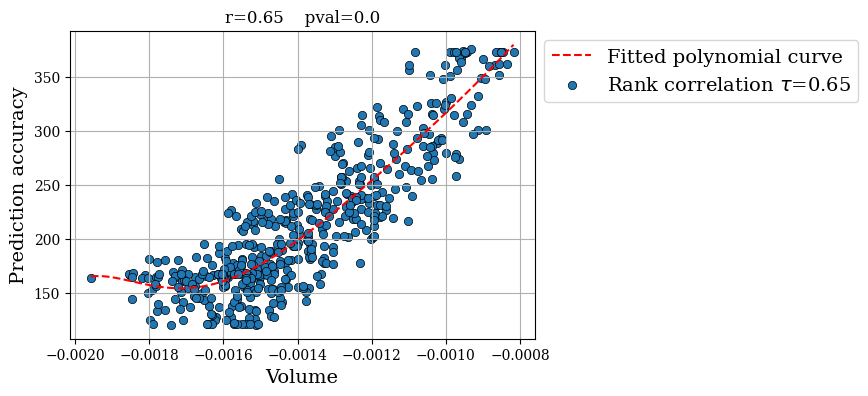

In [ ]:
# d = "bloodmnist"
# d = "dermamnist"
d = 'retinamnist'
# d = "pathmnist"
# d = 'tissuemnist'
# d = 'organamnist'

class_bc = odv_results[d]['class_bc']
vs = odv_results[d]['vs']
bin_odv = odv_results[d]['bin_opendataval']
multi_odv = odv_results[d]['multi_opendataval']
cluster_odv = odv_results[d]['cluster_opendataval']
bin_us = odv_results[d]['bin_us']
multi_us= odv_results[d]['multi_us']
cluster_us = odv_results[d]['cluster_us']
num_corr_class = odv_results[d]['num_corr_class']

# _x = [v["l2"] for v in vs]
# _x = [v["cosine"] for v in vs]
# _x = [v["relevance"] for v in vs]
# _x = [v["dispersion"] for v in vs]
# _x = [v["volume"] for v in vs]
# _x = [v["vendi"] for v in vs]

_x = [v["KNN Shapley"] for v in cluster_odv]
# _x = [v["LAVA"] for v in cluster_odv]

_y = num_corr_class
# _y = bin_us
# _y = multi_us
# _y = cluster_us

coefficients = np.polyfit(_x, _y, 10)# Fit the polynomial (degree 2)
polynomial = np.poly1d(coefficients)# Create a polynomial function with the fitted coefficients
x_fit = np.linspace(min(_x), max(_x), 100)# Generate x values for plotting the polynomial fit
y_fit = polynomial(x_fit)
# r = pearsonr(_x, _y)
r = kendalltau(_x, _y)
plt.figure(figsize=(6, 4))
plt.plot(x_fit, y_fit, color='red', label='Fitted polynomial curve', ls='--')
plt.scatter(
    _x, _y,
    label = fr"Rank correlation $\tau$={round(r.statistic, 2)}",
    edgecolors='k',
    lw=0.5,
)
plt.title(f"r={round(r.statistic, 2)}    pval={round(r.pvalue, 6)}")
# plt.title(fr"$\tau$={round(r.statistic, 2)}", fontsize=14)
plt.grid()
# plt.xlabel('Data measurement', fontsize=14)
# plt.xlabel('Relevance', fontsize=14)
plt.xlabel('Volume', fontsize=14)
# plt.xlabel('Number of data points with relevant labels', fontsize=14)
plt.ylabel('Prediction accuracy', fontsize=14)
# plt.ylim(0.0, 1)
plt.legend(fontsize=14, bbox_to_anchor=(1, 1))
# plt.savefig(fig_dir / f"{d}_correlation_multi.eps", bbox_inches='tight')
# plt.savefig(fig_dir / f"{d}_correlation_cluster.eps", bbox_inches='tight')
